# First simulation with OpenMM

## 1. Force field definition and energy minimization

The first simulation below is a minimal example of a molecular system: just a single water molecule. Initially, only the energy of this system is minimized.
This example consists of a few steps:

### Import OpenMM and NumPy python packages

These packages must be imported before one can use OpenMM.
In this notebook NumPy is only used to define an array with initial positions and to analyze simulation results.


In [1]:
%matplotlib widget

In [2]:
from sys import stdout

import matplotlib.pyplot as plt
import mdtraj
import nglview
import numpy as np
import pandas
from openmm import *
from openmm.app import *
from openmm.unit import *

### Units

OpenMM uses internally consistent units based on the SI system, as documented [here](http://docs.openmm.org/latest/userguide/theory.html#units).
One may easily convert values with different unit, as shown in the examples below.

In [3]:
# Assign a value of 10 picoseconds
time = 10 * picosecond  # 10 * picoseconds will also work.
print("Unit of variable time:", time.unit)
print("time:", time)
print("time [s]:", time / second)
print("time [s]:", time / seconds)
print("time [fs]:", time.value_in_unit(femtosecond))
print("time:", time.in_units_of(femtosecond))

# OpenMM also knows a few important constants.
print("Boltzmann's constant:", BOLTZMANN_CONSTANT_kB)
print("Avogadro's constant:", AVOGADRO_CONSTANT_NA)

Unit of variable time: picosecond
time: 10 ps
time [s]: 1e-11
time [s]: 1e-11
time [fs]: 10000.0
time: 10000.0 fs
Boltzmann's constant: 1.380649e-23 J/K
Avogadro's constant: 6.02214076e+23 /mol


The API documentation for quantities with units can be found here:

http://docs.openmm.org/latest/api-python/generated/openmm.unit.quantity.Quantity.html

A complete overview of units and constant can be found in the Python wrapper source code for OpenMM: 

* Units: https://github.com/openmm/openmm/blob/master/wrappers/python/openmm/unit/unit_definitions.py
* Constants: https://github.com/openmm/openmm/blob/master/wrappers/python/openmm/unit/constants.py

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> - Try to change (femto)second(s) in (femto)meter(s) in the above example. Why does this work or fail in each case?
>
> - Print $k_B T$ in $\textrm{kJ}\,\textrm{mol}^{-1}$, where $k_B$ is the gas constant and $T=293.15\,\textrm{K}$. This is the average amount of (kinetic and potential) thermal energy per degree of freedom in a system, at room temperature.
>
> - Use the Boltzmann constant and the Avogadro constant to express the universal gas constant in $\textrm{kJ}\,\textrm{K}^{-1}\,\textrm{mol}^{-1}$.

### Define the topology

In normal OpenMM usage, the topology is defined by a PDB file.
In this example, it is defined from scratch by creating objects in Python code, to show explicitly how the topology is built up.
Similar data structures are created when loading topologies from files.

Note that a topology in biomolecular simulations consists of a group of chains, where a chain consists of multiple residues and every residue contains a set of atoms, which are connected by bonds.
This terminology was originally defined for describing proteins in the PDB file format, see http://www.wwpdb.org/documentation/file-format.
In biomolecular simulations, the same terminology is nowadays also used for other things than proteins.
For example, here we have a chain with a single residue, a water molecule, containing three atoms and two bonds.

In [4]:
topology = Topology()
chain = topology.addChain()
residue = topology.addResidue("water", chain)
element_O = Element.getByAtomicNumber(8)
element_H = Element.getByAtomicNumber(1)
atom0 = topology.addAtom("O", element_O, residue)
atom1 = topology.addAtom("H", element_H, residue)
atom2 = topology.addAtom("H", element_H, residue)
topology.addBond(atom0, atom1)
topology.addBond(atom0, atom2)

In [5]:
topology

<Topology; 1 chains, 1 residues, 3 atoms, 2 bonds>

### Set up the simulation

This part consists of a few steps:

1. Select the TIP3P-FB **force field definition** for water, see https://doi.org/10.1021/jz500737m. The file `tip3pfb.xml` is included in the OpenMM installation. It's contents can also be viewed online, see https://github.com/openmm/openmm/blob/master/wrappers/python/openmm/app/data/amber14/tip3pfb.xml

1. Define a **system**, which is essentially an object implementing the selected force field for our topology. This object can compute energies and forces.

1. Define an **integrator**, which implements a molecular dynamics algorithm, in this case the Verlet algorithm sampling the NVE ensemble. Even though we will initially only carry out a geometry optimization, OpenMM requires us to define an integrator.

1. Define a **simulation**, which has the following responsibilities:

   - keep track of the current state (atomic positions etc.), 
   
   - decide which implementation to use (CPU versus GPU)
   
   - drive the integrator and 
   
   - write output files (reporters).
  
This simple example does not write any output yet. The initial positions are provided as a NumPy array, multiplied by a unit. Each row in the array contains the X, Y and Z coordinates of one atomic nucleus, in the same order as the atoms in the topology. Normally, also these initial positions are loaded from a PDB file.

In [6]:
# a. Select the TIP3P-FB force field.
forcefield = ForceField("amber14/tip3pfb.xml")

# b. Create an object to compute energies and forces for our topology.
system = forcefield.createSystem(topology, nonbondedCutoff=1 * nanometer)

# c. Definition an integrator, mandatory.
integrator = VerletIntegrator(1 * femtoseconds)

# d. A simulation object in OpenMM combines topology, system and integrator.
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(
    np.array(
        [
            [0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0],
            [0.0, 1.0, 0.0],
        ]
    )
    * angstroms
)

### Minimize the energy

Also this part is split up in a few steps:

1. Before minimizing, compute and print the **energy** of the **initial** state.

1. **Minimize** the energy. This is a black-box procedure, using the L-BFGS algorithm.
   Tracking the progress during the minimization is not possible yet, see https://github.com/openmm/openmm/issues/1155.

1. Compute and print the **energy** of the **final** state.

In [7]:
# a. Print the energy before minimizing.
state0 = simulation.context.getState(getEnergy=True)
print(state0.getPotentialEnergy())

# b. Minimize the energy.
simulation.minimizeEnergy()

# c. Print the energy afterwards.
state1 = simulation.context.getState(getEnergy=True)
print(state1.getPotentialEnergy())

42.62383270263672 kJ/mol
1.2486228115449194e-05 kJ/mol


## 2. Inspection of OpenMM data structures

Before performing other simulations, we take a closer look at the objects created in the previous example to understand how OpenMM works. To access the internals, we use the so-called Python Application Programming Interface (API) of OpenMM, which is documented here: http://docs.openmm.org/latest/api-python/index.html.

The API documentation contains tables with class names, like `Topology`, and their corresponding purpose. Clicking on the class name brings you to a page with more details.

### Topology

The `Topology` class is documented here: http://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Topology.html#openmm.app.topology.Topology

In [8]:
# The print lines below show details of the topology.
print(topology)
print("Number of atoms:", topology.getNumAtoms())
print("Periodic boundaries:", topology.getUnitCellDimensions())
for iatom, atom in enumerate(topology.atoms()):
    # The following-line would just print a dictionary
    # with all attributes, useful to explore undocumented
    # attributes.
    # print(vars(atom))
    print(f"Name and mass of atom {iatom}: {atom.name}, {atom.element.mass}")

<Topology; 1 chains, 1 residues, 3 atoms, 2 bonds>
Number of atoms: 3
Periodic boundaries: None
Name and mass of atom 0: O, 15.99943 Da
Name and mass of atom 1: H, 1.007947 Da
Name and mass of atom 2: H, 1.007947 Da


**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Extend the code cell above to loop over the bonds and to print the corresponding pair of atoms.

### System

The relevant API documentation can be found here:

* `System` class: http://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html#openmm.openmm.System
* `HarmonicBondForce` class: http://docs.openmm.org/latest/api-python/generated/openmm.openmm.HarmonicBondForce.html#openmm.openmm.HarmonicBondForce

In [9]:
# Loop over all contributions to the force evaluation.
# Note that not all terms are real force-field contributions.
# The last one zeros to center-of-mass momentum at every step.
for force in system.getForces():
    print(force)
print()
# The force field contains two harmonic bond terms,
# with the same parameters.
force_bond = system.getForce(0)
for ibond in range(force_bond.getNumBonds()):
    print(force_bond.getBondParameters(ibond))
    print()

<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7fef842ba730> >
<openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7fef842bacd0> >
<openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7fef842bad00> >
<openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7fef842b9e30> >

[0, 1, Quantity(value=0.101181082494, unit=nanometer), Quantity(value=462750.4, unit=kilojoule/(nanometer**2*mole))]

[0, 2, Quantity(value=0.101181082494, unit=nanometer), Quantity(value=462750.4, unit=kilojoule/(nanometer**2*mole))]



**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Add code to show the angle force terms of the system and the corresponding parameters. Do these match the definition of the force field in the `tip3pfb.xml` file?

### System state

A `Simulation` object has a `context` attribute, through which many details of the simulation can be accessed. Here we use it to retrieve the current state of our molecular model. The `Context` class is documented here: http://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context

Below, the `getState` method retrieves a `State` object with results for the final geometry of the water molecule. The `State` class is documented here: http://docs.openmm.org/latest/api-python/generated/openmm.openmm.State.html#openmm.openmm.State

In [10]:
# Simply extract and print information
state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
print("Potential energy: ", state.getPotentialEnergy())
print()
print("Atomic positions")
print(state.getPositions(asNumpy=True))
print()
print("Forces")
print(state.getForces(asNumpy=True))
print()

Potential energy:  1.2486228115449194e-05 kJ/mol

Atomic positions
[[ 0.          0.00534427  0.00534427]
 [ 0.         -0.01060477  0.10526051]
 [ 0.          0.1052605  -0.01060477]] nm

Forces
[[ 0.          1.65714926  1.66899399]
 [ 0.         -1.40472912 -0.26263409]
 [ 0.         -0.25242013 -1.40635987]] kJ/(nm mol)



In [11]:
# One can use NumPy to get a few geometry properties:

# The length of the first O-H bond, in nanometers.
pos = state.getPositions(asNumpy=True)
print(np.linalg.norm(pos[1] - pos[0]))

# The H-O-H angle, in degrees
d01 = pos[1] - pos[0]
d02 = pos[2] - pos[0]
d01 /= np.linalg.norm(d01)
d02 /= np.linalg.norm(d02)
cosine = np.dot(d01, d02)
print(np.arccos(cosine) * 180 / np.pi)

0.10118115878989922
108.13854873886349


## 3. PDB output and visualization

The following is a minimal example writing out the current positions to a PDB file, after which NGLView is used to visualize the structure. See http://nglviewer.org/nglview/latest/.

In [12]:
# NGLView is a structure and trajectory visualization that integrates well with Jupyter Notebooks.

# Write out a PDB file
with open("water.pdb", "w") as outfile:
    PDBFile.writeFile(topology, pos, outfile)
# Visualize
nglview.show_mdtraj(mdtraj.load("water.pdb"))

NGLWidget()

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Check the contents of the file `water.pdb`. It should contain the Cartesian coordinates of the optimized geometry.

## 4. A short molecular dynamics simulation

In the code cells above, a verlet integrator was defined, which we will use in this section.

Before performing the MD, some more initialization steps are needed:

- Velocities are assigned random values sampled from the Maxwell-Boltzmann distribution.

- Three reporters are attached to the simulation to store the output in files and to track the progress on screen. The reporter API is documented here: http://docs.openmm.org/latest/api-python/app.html#reporting-output

In [13]:
# Initialize velocities with random values at 300K.
# The random seed is fixed (to 1). This way, rerunning
# this cell will generate the same random velocities.
simulation.context.setVelocitiesToTemperature(300, 1)

# Remove existing reporters,
# in case this cell is executed more than once.
simulation.reporters = []

# Write a frame to the PDB trajectory every step.
simulation.reporters.append(PDBReporter("traj.pdb", 1))

# Write scalar properties to a CSV file every step.
simulation.reporters.append(
    StateDataReporter(
        "scalars.csv",
        1,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)

# Write scalar properties to screen every 100 steps.
simulation.reporters.append(
    StateDataReporter(stdout, 100, step=True, totalEnergy=True, temperature=True)
)

# Actually run the molecular dynamics simulation.
simulation.step(1000)

#"Step","Total Energy (kJ/mole)","Temperature (K)"
100,5.835020311176777,229.0913692770577
200,5.8338115736842155,231.44932203833173
300,5.838252671062946,229.45737339499044
400,5.846107512712479,227.8361665443331
500,5.863014154136181,222.3372459418655
600,5.8752780854702,221.687837411985
700,5.884814761579037,217.56128745712198
800,5.904089152812958,211.61541961885658
900,5.923820368479937,204.80300563058734
1000,5.945065200328827,199.04898302170326


We will load the trajectory again with MDTraj and pass on this information to nglview to visualize the motion of the water molecule. See http://mdtraj.org/.

In [14]:
nglview.show_mdtraj(mdtraj.load("traj.pdb"))

NGLWidget(max_frame=999)

The following example shows how to load the data from the CSV file and plot it, using Pandas. Under the hood pandas uses MatPlotLib to make the figure. In the example below, two curves are put on the same plot by plotting them in the same MatPlotLib axes.

See https://pandas.pydata.org/ and https://matplotlib.org/.

Because the OpenMM write slightly non-standard CSV output, the header of the first column contains a few spurious characters.

In [3]:
# The following line is needed to obtain an interactive plot.
df = pandas.read_csv("scalars.csv")
# To show the contents of a Pandas Dataframe, just put
# the variable on the last line.
df

#"Time (ps)"  Potential Energy (kJ/mole)  Total Energy (kJ/mole)  \
0           0.001                    0.806609                5.926392   
1           0.002                    1.817138                6.051976   
2           0.003                    1.273291                5.983334   
3           0.004                    0.132272                5.840408   
4           0.005                    0.390756                5.872072   
..            ...                         ...                     ...   
995         0.996                    0.546616                5.891695   
996         0.997                    0.150691                5.838345   
997         0.998                    1.167627                5.963603   
998         0.999                    1.839925                6.048976   
999         1.000                    0.980109                5.945065   

     Temperature (K)  
0         205.256106  
1         169.777969  
2         188.829327  
3         228.843629  
4         219.750259  
..               ...  
995       214.288407  
996       228.022485  
997       192.274430  
998       168.744186  
999       199.048983  

[1000 rows x 4 columns]

In [4]:
%matplotlib ipympl

<Axes: xlabel='#"Time (ps)"'>

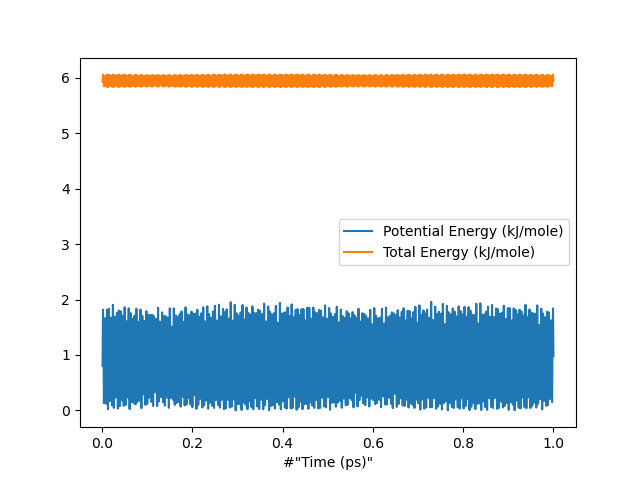

In [5]:
# Plot the potential and total energy as function of time.
ax = plt.gca()
df.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)", ax=ax)
df.plot(kind="line", x='#"Time (ps)"', y="Total Energy (kJ/mole)", ax=ax)

<Axes: xlabel='#"Time (ps)"'>

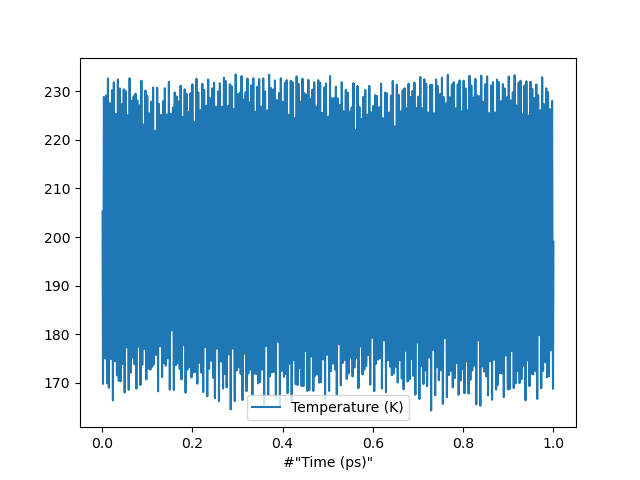

In [17]:
df.plot(kind="line", x='#"Time (ps)"', y="Temperature (K)")

The oscillations in the potential energy are normal. Due to the molecular vibrations, there is a continuous exchange between kinetic and potential energy. In principle, the total energy should be conserved exactly. In simulations, it is only approximately conserved because the Velocity Verlet scheme uses a finite-difference approximation. For practical applications, it is sufficient to observe no systematic drift in the conserved quantity.

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Experiment with this notebook to get some experience with molecular dynamics simulations:
>
> - The timestep is set to $1 \text{ fs}$ when creating the `VerletIntegrator` object. Increase the time step until the total energy is no longer conserved. What happens?
>
> - Replace the `VerletIntegrator` by a `LangevinIntegrator` at a temperature of 300 Kelvin, with a friction coefficient of 10 inverse picoseconds and step size of 1 femtosecond. The API documentation can be found here: http://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinIntegrator.html#openmm.openmm.LangevinIntegrator
>
> - Make modifications to the topology to understand which parts are essential to generate the system object with the correct parameters. Try making changes to: (i) the atom names, (ii) the element numbers, (iii) the bonds, (iv) the name of the residue and (v) the order of the atoms.